In [1]:
%matplotlib inline
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
import xgboost as xgb

import custom_helpers as ch

import warnings
warnings.filterwarnings('ignore')

# load data with helper function
data = ch.load_data('../data/train_month_3_with_target.csv')

/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


------------------------------------------------------------
loading data...
transforming dates...
cast types into bool, object, categorical...
data loaded and casted
------------------------------------------------------------


# Preprocessing

In [2]:
y = data.target
X = data.drop(columns = ['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train, random_state=42)

num_col = X_train.select_dtypes(include = 'number', exclude = 'bool').columns
cat_col = X_train.select_dtypes(include = 'category').columns
bool_col = X_train.select_dtypes(include = 'bool').columns
date_col = X_train.select_dtypes(include = 'datetime64').columns
obj_col = X_train.select_dtypes(include = 'object').columns

# found during exploratory phase
colinear_features = ['bal_insurance_23',
     'bal_insurance_21',
     'bal_savings_account_starter',
     'has_homebanking',
     'customer_since_bank_years',
     'cap_life_insurance_decreasing_cap',
     'has_mortgage_loan',
     'has_fire_car_other_insurance',
     'bal_pension_saving',
     'bal_personal_loan']


numeric_transformer = Pipeline(steps = [
    ('impute',SimpleImputer(missing_values=np.nan, strategy='median'))
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")


preprocessor = ColumnTransformer(
    transformers=[
        ('drop_ID','drop',obj_col),
        ('drop_dates','drop',date_col),
        ('drop_colinear', 'drop', colinear_features),
        ('cat',categorical_transformer,cat_col),
        ('num',numeric_transformer,num_col)
    ],
    remainder = "passthrough"
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# First Pass without Parameter Tuning

In [3]:
# #classifier
# xg = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,seed = 42)

# clf = xg.fit(X_train, y_train,
#              eval_set = [(X_test, y_test)], 
#              eval_metric = 'auc',
#              early_stopping_rounds = 10,
#              verbose = True)

# ch.evaluate(clf, X_test, y_test)

In [4]:
# First Round
param_grid = {
    'max_depth' : [3,4,5],
    'learning_rate' : [0.01,0.05,0.1],
    'reg_lambda' : [0,1,10],
    'gamma':[0.05,0.25,1],
    'scale_pos_weight': [1,3,5] #use in the neighbourhood of sum(neg)/sum(pos)
}

search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'
                                        , subsample = 0.9
                                        , colsample_bytree = 0.5
                                        , use_label_encoder=False
                                        , verbosity = 0
                                        , seed = 42)
                      , param_grid
                      , scoring = 'roc_auc'
                      , verbose = 1
                      , cv = 3
                      , n_jobs=-2
                     )


search.fit(X_train, y_train
             , eval_set = [(X_val, y_val)]
             , eval_metric = 'auc'
             , early_stopping_rounds = 10
             , verbose = False
          )

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use panda

Best parameter (CV score=0.733):
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10, 'scale_pos_weight': 1}


In [5]:
#Second Round
param_grid = {
    'max_depth' : [3],
    'learning_rate' : [0.1,0.5,1],
    'reg_lambda' : [10,20,100],
    'gamma':[0.01,0.1],
    'scale_pos_weight': [5,7,10] #use in the neighbourhood of sum(neg)/sum(pos)
}

search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'
                                        , subsample = 0.9
                                        , colsample_bytree = 0.5
                                        , use_label_encoder=False
                                        , verbosity = 0
                                        , seed = 42)
                      , param_grid
                      , scoring = 'roc_auc'
                      , verbose = 1
                      , cv = 3
                      , n_jobs=-2)


search.fit(X_train, y_train
             , eval_set = [(X_val, y_val)]
             , eval_metric = 'auc'
             , early_stopping_rounds = 10
             , verbose = False)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameter (CV score=0.731):
{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 100, 'scale_pos_weight': 5}


In [6]:
clf = search.best_estimator_.fit(X_train, y_train
             , eval_set = [(X_val, y_val)]
             , eval_metric = 'auc'
             , early_stopping_rounds = 10
             , verbose = False)
#clf = search.best_estimator_

# make prediction on test
y_pred_test = clf.predict(X_test)
y_pred_test_probs = clf.predict_proba(X_test)

ch.evaluate(clf, X_test, y_test)

------------------------------------------------------------
Performance Over Whole Set
------------------------------------------------------------
               precision    recall  f1-score   support

Did not Churn       0.97      1.00      0.98     12357
        Churn       0.15      0.01      0.02       383

     accuracy                           0.97     12740
    macro avg       0.56      0.50      0.50     12740
 weighted avg       0.95      0.97      0.95     12740

------------------------------------------------------------
AUC: 0.50
No. of TP (precision@250): 38
------------------------------------------------------------


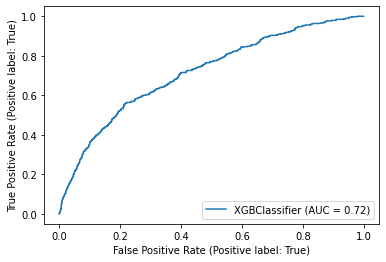

In [7]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [8]:
# run on submission data
X_sub = ch.load_data('../data/test_month_3.csv')
df = preprocessor.transform(X_sub)

# make prediction on test
y_pred_sub = clf.predict(df)
y_pred_test_sub = clf.predict_proba(df)
y_pred_test_sub_pos = y_pred_test_sub[:,1]

df = pd.DataFrame({'ID': X_sub.client_id,'class': y_pred_sub,'PROB':y_pred_test_sub_pos})


# today = dt.datetime.today()
# df.to_csv(f'../output/xg_{today.month}{today.day}.csv', index = False)

------------------------------------------------------------
loading data...
transforming dates...
cast types into bool, object, categorical...
data loaded and casted
------------------------------------------------------------


In [9]:
df['PROB'].describe()

count    27300.000000
mean         0.121748
std          0.095389
min          0.018679
25%          0.051580
50%          0.083156
75%          0.162767
max          0.587949
Name: PROB, dtype: float64

<AxesSubplot:xlabel='PROB', ylabel='Count'>

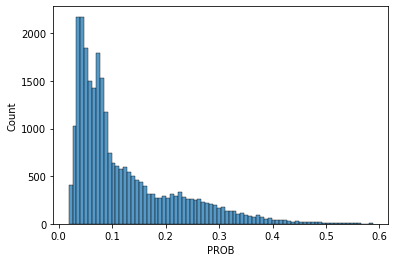

In [10]:
sns.histplot(df['PROB'])